# Organized Notes: Implementing Autoencoders in Keras: Tutorial
A notebook based on DataCamp tutorial aiming at gaining a preliminary understanding towards Convolutional networks. (Autoencoder in this case specifically)

**Data**: NotMNIST dataset comprises 28x28 grayscale images of 70,000 letters from A - J in total 10 categories, and 6,000 images per category.


In [1]:
# if you train on a GPU and use Jupyter Notebook, 
# you will need to add three more lines of code where you specify CUDA device order 
# and CUDA visible devices using a module called os.

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0

In [2]:
# Import modules

import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load the data

In [3]:
def extract_data(filename, num_images):
    """opens a gzip file and return data inside as numpy array
    Arguments:
        filename: str
        num_images:int
    Return:
        data: numpy array float32
    """
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [4]:
train_data = extract_data('notMNIST-to-MNIST/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('notMNIST-to-MNIST/t10k-images-idx3-ubyte.gz', 10000)

In [5]:
def extract_labels(filename, num_images):
    """opens a gzip file and return data inside as numpy array
    Arguments:
        filename: str
        num_images:int
    Return:
        data: numpy array int64
    """
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [6]:
# dim: 60,000*1
train_labels = extract_labels('notMNIST-to-MNIST/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('notMNIST-to-MNIST/t10k-labels-idx1-ubyte.gz',10000)

## Data Exploration

In [7]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [8]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5,1,'(Label: D)')

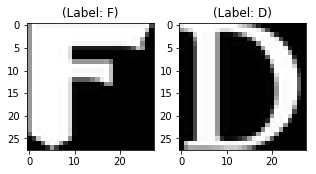

In [9]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

## Data Preprocessing

In [10]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [11]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [12]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [13]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [14]:
# divide training data in to training and validation sets

from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

## The Convolutional Antoencoder

As discussed before, the autoencoder is divided into two parts: there's an encoder and a decoder.  
Encoder
* The first layer will have 32 filters of size 3 x 3, followed by a downsampling (max-pooling) layer,
* The second layer will have 64 filters of size 3 x 3, followed by another downsampling layer,
* The final layer of encoder will have 128 filters of size 3 x 3.


Decoder
* The first layer will have 128 filters of size 3 x 3 followed by a upsampling layer,/li>
* The second layer will have 64 filters of size 3 x 3 followed by another upsampling layer,
* The final layer of encoder will have 1 filter of size 3 x 3.
* The max-pooling layer will downsample the input by two times each time you use it, while the upsampling layer will upsample the input by two times each time it is used.


In [15]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [16]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [17]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [18]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         147584    
__________

In [19]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 8s 172us/step - loss: 0.0355 - val_loss: 0.0126
Epoch 2/50
48000/48000 [==============================] - 5s 113us/step - loss: 0.0101 - val_loss: 0.0080
Epoch 3/50
48000/48000 [==============================] - 5s 114us/step - loss: 0.0072 - val_loss: 0.0060
Epoch 4/50
48000/48000 [==============================] - 5s 113us/step - loss: 0.0059 - val_loss: 0.0059
Epoch 5/50
48000/48000 [==============================] - 5s 112us/step - loss: 0.0050 - val_loss: 0.0047
Epoch 6/50
48000/48000 [==============================] - 5s 114us/step - loss: 0.0043 - val_loss: 0.0043
Epoch 7/50
48000/48000 [==============================] - 5s 114us/step - loss: 0.0039 - val_loss: 0.0035
Epoch 8/50
48000/48000 [==============================] - 5s 114us/step - loss: 0.0035 - val_loss: 0.0030
Epoch 9/50
48000/48000 [==============================] - 6s 115us/step - loss: 0.0033 - val_loss: 0.0

### Training and Validation Loss Plot

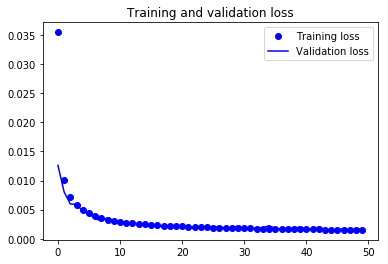

In [20]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predicting on Test Data

In [21]:
pred = autoencoder.predict(test_data)
pred.shape

(10000, 28, 28, 1)

Test Images


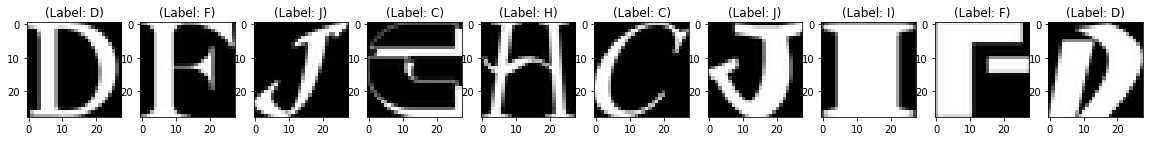

Reconstruction of Test Images


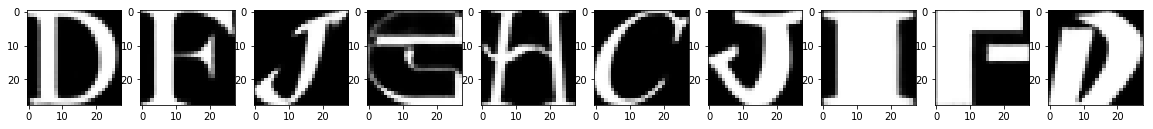

In [22]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

# Denoising Autoencoder

A denoising autoencoder tries to **learn a representation (latent-space or bottleneck) that is robust to noise**. You add noise to an image and then feed the noisy image as an input to the enooder part of your network. The encoder part of the autoencoder transforms the image into a different space that tries to preserve the alphabets but removes the noise.  

But how does it exactly remove the noise?  

During training, you define a loss function, similar to the root mean squared error that you had defined earlier in convolutional autoencoder. At every iteration of the training, the network will **compute a loss between the noisy image outputted by the decoder and the ground truth (denoisy image)** and will also try to minimize that loss or difference between the reconstructed image and the original noise-free image.

### Adding Noise to Image

In [24]:
noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
# np.clip() will threshold all the negative values to zero and all the values greater than one to one. 

### Visualizing the Noisy Image

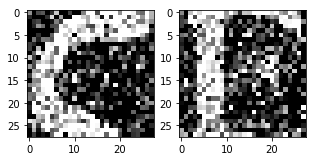

In [25]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

<span style="font-size: 14pt;"> Denoising Autoencoder Network  </span>

As discussed before the autoencoder is divided into two parts: the encoder and the decoder. The architecture that you're going to construct will look like the following:  
Encoder  
* The first layer will have 32-3 x 3 filters followed by a downsampling (max-pooling) layer,
* The second layer will have 64-3 x 3 filters followed by another downsampling layer,
* The final layer of encoder will have 128-3 x 3 filters.


Decoder  
* The first layer will have 128-3 x 3 filters followed by a upsampling layer,
* The second layer will have 64-3 x 3 filters followed by another upsampling layer,
* The final layer of encoder will have 1-3 x 3 filters.


In [26]:
batch_size = 128
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [27]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [28]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

### Training

In [29]:
autoencoder_train = autoencoder.fit(x_train_noisy, train_X, batch_size=batch_size,
                                    epochs=epochs,verbose=1,validation_data=(x_valid_noisy, valid_X))


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 5s 114us/step - loss: 0.0522 - val_loss: 0.0265
Epoch 2/20
48000/48000 [==============================] - 5s 114us/step - loss: 0.0241 - val_loss: 0.0247
Epoch 3/20
48000/48000 [==============================] - 6s 115us/step - loss: 0.0207 - val_loss: 0.0204
Epoch 4/20
48000/48000 [==============================] - 5s 113us/step - loss: 0.0190 - val_loss: 0.0189
Epoch 5/20
48000/48000 [==============================] - 6s 116us/step - loss: 0.0179 - val_loss: 0.0177
Epoch 6/20
48000/48000 [==============================] - 5s 114us/step - loss: 0.0171 - val_loss: 0.0162
Epoch 7/20
48000/48000 [==============================] - 6s 116us/step - loss: 0.0166 - val_loss: 0.0170
Epoch 8/20
48000/48000 [==============================] - 6s 116us/step - loss: 0.0161 - val_loss: 0.0168
Epoch 9/20
48000/48000 [==============================] - 6s 116us/step - loss: 0.0158 - val_loss: 0.0

### Train vs. Validation Plot

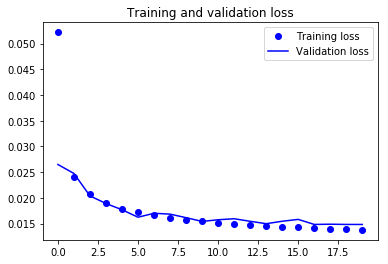

In [30]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predicting

In [31]:
pred = autoencoder.predict(x_test_noisy)


Test Images


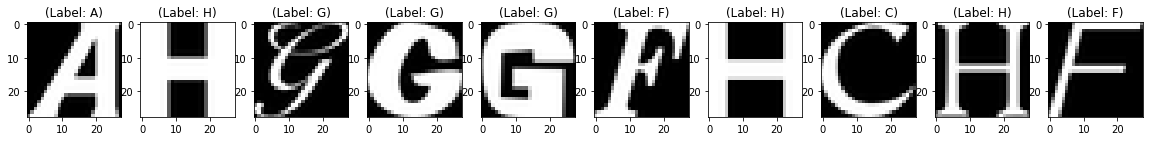

Test Images with Noise


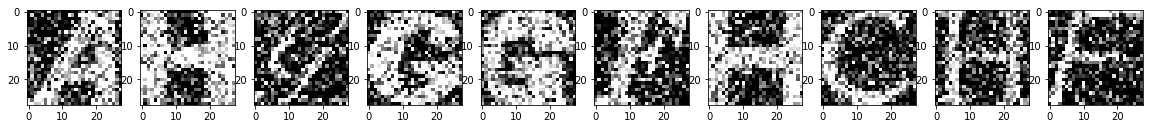

Reconstruction of Noisy Test Images


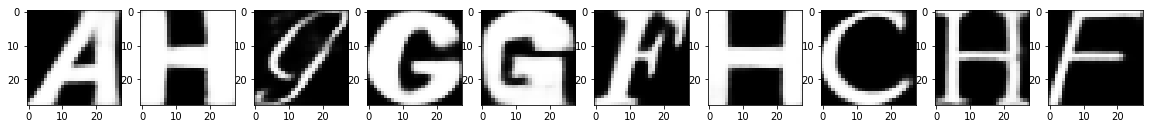

In [32]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()